# BirdMerge Preprocessing of CUB-200

In [1]:
import os
from PIL import Image
import cv2
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from dataloader import *

In [2]:
CUB_DIRPATH = "CUB_200_2011/CUB_200_2011/"
BBOX_FILEPATH = os.path.join(CUB_DIRPATH, "bounding_boxes.txt")
IMG_DIRPATH = os.path.join(CUB_DIRPATH, "images")
IMGLIST_FILEPATH = os.path.join(CUB_DIRPATH, "images.txt")
ATTRIBUTES_FILEPATH = os.path.join(CUB_DIRPATH, "attributes", "attributes.txt")
IMG_ATTRIBUTES_FILEPATH = os.path.join(CUB_DIRPATH, "attributes", "image_attribute_labels.txt")
OUTPUT_DIRPATH = "images-processed"
OUTPUTLIST_FILEPATH = "images-processed.txt"

FEATURES_DF_PKL_FILEPATH = 'features_df.pkl'

### Pad/Resize by BBOX

In [3]:
def pad_and_resize(image_path, bbox, target_size):
    image = cv2.imread(image_path)
    img_h, img_w, _ = image.shape
    
    x, y, w, h = bbox
    
    target_w, target_h = target_size
    target_aspect_ratio = target_w / target_h
    
    bbox_aspect_ratio = w / h
    
    # Calculate padded bounding box coordinates
    if bbox_aspect_ratio > target_aspect_ratio:
        # Pad height to match target aspect ratio
        pad_h = int(w / target_aspect_ratio) - h
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = 0
        pad_right = 0
    else:
        # Pad width to match target aspect ratio
        pad_w = int(h * target_aspect_ratio) - w
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        pad_top = 0
        pad_bottom = 0
    
    # Apply padding to bounding box
    padded_x = x - pad_left
    padded_y = y - pad_top
    padded_w = w + pad_left + pad_right
    padded_h = h + pad_top + pad_bottom
    
    # Check if padded bounding box exceeds image bounds
    if padded_x < 0 or padded_y < 0 or padded_w <= 0 or padded_h <= 0 or padded_x + padded_w > img_w or padded_y + padded_h > img_h:
        return None
    
    # Extract padded region from image
    padded_x, padded_y, padded_w, padded_h = int(padded_x), int(padded_y), int(padded_w), int(padded_h)
    padded_img = image[padded_y:padded_y+padded_h, padded_x:padded_x+padded_w]

    # Resize padded image to target size
    resized_img = cv2.resize(padded_img, target_size)

    # Preview final cropped img
    cv2.rectangle(image, (padded_x, padded_y), (padded_x+padded_w, padded_y+padded_h), (255, 0, 0), 2)
    cv2.imwrite('box_preview.png', image)
    
    return resized_img


In [4]:
bboxes = dict()
img_paths = dict()

with open(BBOX_FILEPATH, "r") as file:
    for line in file:
        lines = line.strip()
        lines = lines.split(" ")
        bboxes[int(lines[0])] = (float(x) for x in lines[1:])

with open(IMGLIST_FILEPATH, "r") as file:
    for line in file:
        lines = line.strip()
        lines = lines.split(" ")
        img_paths[int(lines[0])] = lines[1]

In [5]:
target_size = (128, 128)
cnt = 0

for i, rel_filepath in img_paths.items():
    file_path = os.path.join(IMG_DIRPATH, rel_filepath) 
    resized_img = pad_and_resize(file_path, bboxes[i], target_size)
    resized_img_filepath = os.path.join(OUTPUT_DIRPATH, rel_filepath)
    if resized_img is not None:
        os.makedirs(os.path.dirname(resized_img_filepath), exist_ok=True)
        cv2.imwrite(os.path.join(OUTPUT_DIRPATH, rel_filepath), resized_img)
        cnt += 1
print(f"{cnt} / {len(img_paths)} images met the BBOX criteria")        

8036 / 11788 images met the BBOX criteria


### Attribute Handling

In [8]:
image_attrs = dict()
with open(IMG_ATTRIBUTES_FILEPATH) as f:
    for line in f:
        pattern = r"(?P<image_id>\d+) (?P<attr_id>\d+) (?P<is_present>[01]) (?P<certainty_id>[1234]) (?P<time>[\d\.]+)"
        match = re.match(pattern, line)
        if not match:
            print(f"Could not parse line [{line}].")

        image_id = int(match.group("image_id"))
        attr_id = int(match.group("attr_id"))
        is_present = int(match.group("is_present"))
        certainty_id = int(match.group("certainty_id"))

        attr_val = 0
        if is_present and certainty_id in (3, 4):
            attr_val = 1

        if image_id not in image_attrs:
            image_attrs[image_id] = dict()

        image_attrs[image_id][attr_id] = attr_val

In [9]:
attr_id_mapping = dict()
attr_idx = 0
attr_type_mapping = dict()
with open(ATTRIBUTES_FILEPATH) as f:
    for line in f:
        pattern = r"(?P<attr_id>\d+) (?P<attr_type>\w+)::(?P<attr_name>)"
        match = re.match(pattern, line)
        if not match:
            print(f"Could not parse line [{line}].")

        attr_id = int(match.group("attr_id"))
        attr_type = match.group("attr_type")
        attr_name = match.group("attr_name")

        if attr_type not in attr_type_mapping:
            attr_type_mapping[attr_type] = dict()
            attr_type_mapping[attr_type]["new_id"] = attr_idx
            attr_type_mapping[attr_type]["list"] = list()
            attr_idx += 1
        attr_type_mapping[attr_type]["list"].append(attr_id)

        attr_id_mapping[attr_id] = [attr_type, attr_type_mapping[attr_type]["new_id"], len(attr_type_mapping[attr_type]["list"])]

for id in attr_id_mapping:
    attr_id_mapping[id][2] /= len(attr_type_mapping[attr_id_mapping[id][0]]["list"])

FileNotFoundError: [Errno 2] No such file or directory: 'CUB_200_2011/CUB_200_2011/attributes/attributes.txt'

In [ ]:
new_attrs = dict()

with open(OUTPUTLIST_FILEPATH, 'w') as file:
    for img, attrs in image_attrs.items():
        img_path = img_paths[img]
        if not os.path.exists(os.path.join(OUTPUT_DIRPATH, img_path)):
            continue
        file.write(f"{img} {img_path}\n")

        new_attrs[img] = dict()
        for attr in attrs:
            new_id_mapping = attr_id_mapping[attr]
            new_id = new_id_mapping[1] 
            if new_id not in new_attrs[img]:
                new_attrs[img][new_id] = [new_id_mapping[0], 0]

            if attrs[attr] == 1:
                new_attrs[img][new_id][1] = new_id_mapping[2]
            

In [7]:
for key in new_attrs:
  print(type(new_attrs[key]))

dict_keys([])

In [9]:
# Convert new_attrs dictionary to DataFrame
df = pd.DataFrame.from_dict(new_attrs, orient='index').reset_index()
df.columns = ['image_id'] + [f'{df[col][0][0]}' for col in df.columns[1:]]
df = df.applymap(lambda x: x[1] if isinstance(x, list) else x)

df.head()
# pd.set_option('display.max_rows', None)
# print(df["image_id"])

/var/folders/w8/ssyg3d6j3yd_ybjcx5wptpg80000gn/T/ipykernel_96287/3062938426.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x[1] if isinstance(x, list) else x)


,image_id,has_bill_shape,has_wing_color,has_upperparts_color,has_underparts_color,has_breast_pattern,has_back_color,has_tail_shape,has_upper_tail_color,has_head_pattern,...,has_size,has_shape,has_back_pattern,has_tail_pattern,has_belly_pattern,has_primary_color,has_leg_color,has_bill_color,has_crown_color,has_wing_pattern
0,2,0.000000,0.400000,0.400000,0.866667,0.00,0.400000,0.500000,0.400000,0.909091,...,0.4,1.000000,0.00,0.00,0.00,0.400000,0.133333,0.933333,0.400000,0.00
1,4,0.555556,0.133333,0.133333,0.000000,0.00,0.133333,0.500000,0.866667,0.363636,...,0.8,0.428571,0.25,0.25,0.00,0.133333,0.000000,0.800000,0.866667,0.25
2,9,0.222222,0.133333,0.133333,0.400000,0.25,0.133333,0.833333,0.400000,0.727273,...,0.4,0.071429,0.25,0.25,0.25,0.400000,0.000000,0.400000,0.400000,0.25
3,10,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,12,0.666667,0.133333,0.133333,0.000000,0.25,0.133333,0.666667,0.133333,0.636364,...,0.2,0.714286,0.25,1.00,0.25,0.133333,0.000000,0.400000,0.400000,0.25


Exclude "image_id" for dataset loading:

In [10]:
df = df.drop(columns=["image_id"])
df.head()

,has_bill_shape,has_wing_color,has_upperparts_color,has_underparts_color,has_breast_pattern,has_back_color,has_tail_shape,has_upper_tail_color,has_head_pattern,has_breast_color,...,has_size,has_shape,has_back_pattern,has_tail_pattern,has_belly_pattern,has_primary_color,has_leg_color,has_bill_color,has_crown_color,has_wing_pattern
0,0.000000,0.400000,0.400000,0.866667,0.00,0.400000,0.500000,0.400000,0.909091,0.866667,...,0.4,1.000000,0.00,0.00,0.00,0.400000,0.133333,0.933333,0.400000,0.00
1,0.555556,0.133333,0.133333,0.000000,0.00,0.133333,0.500000,0.866667,0.363636,0.000000,...,0.8,0.428571,0.25,0.25,0.00,0.133333,0.000000,0.800000,0.866667,0.25
2,0.222222,0.133333,0.133333,0.400000,0.25,0.133333,0.833333,0.400000,0.727273,0.400000,...,0.4,0.071429,0.25,0.25,0.25,0.400000,0.000000,0.400000,0.400000,0.25
3,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,0.666667,0.133333,0.133333,0.000000,0.25,0.133333,0.666667,0.133333,0.636364,0.133333,...,0.2,0.714286,0.25,1.00,0.25,0.133333,0.000000,0.400000,0.400000,0.25


In [11]:
with open(FEATURES_DF_PKL_FILEPATH, 'wb') as file:
    pickle.dump(df, file)

### Displaying First Batch of Dataloader

In [12]:
with open(FEATURES_DF_PKL_FILEPATH, 'rb') as file:
    df = pickle.load(file)

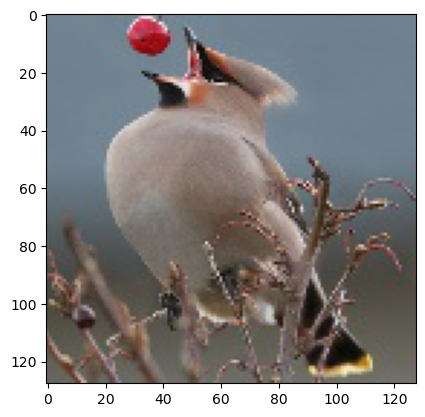

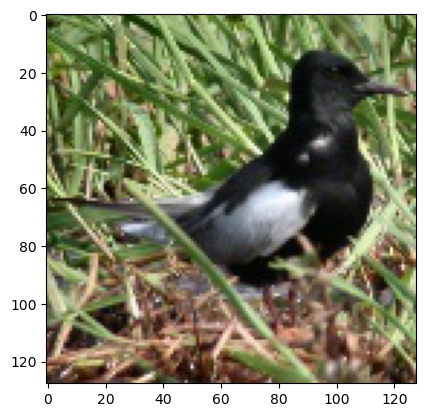

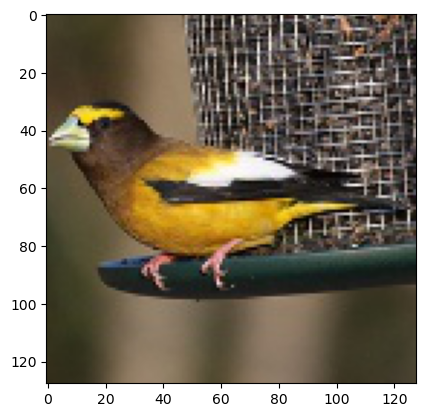

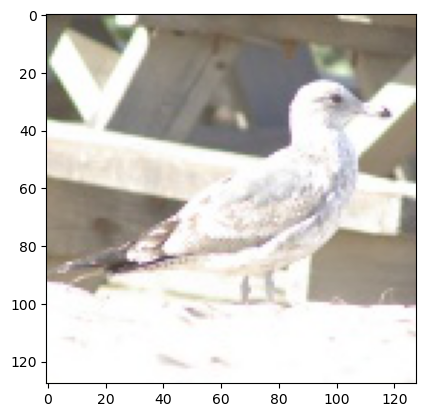

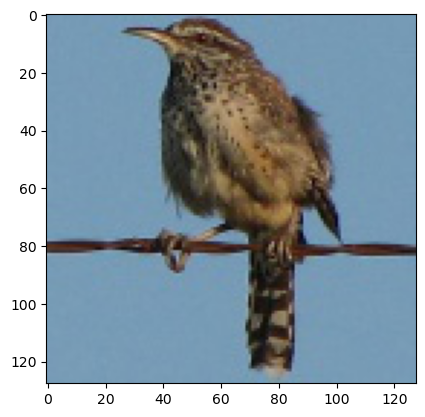

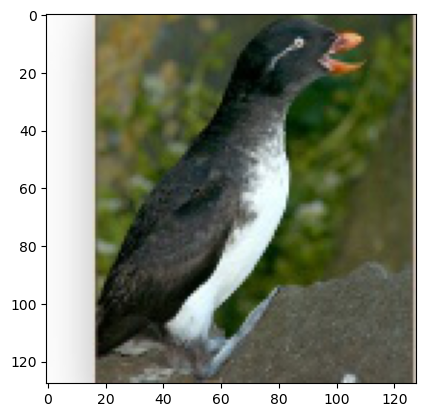

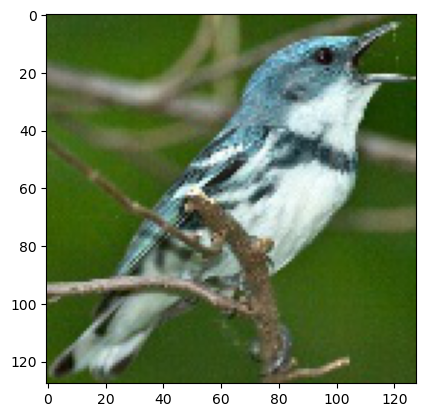

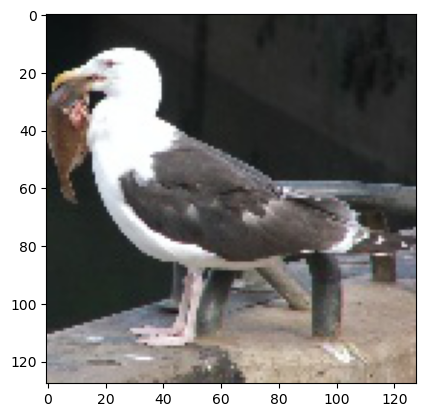

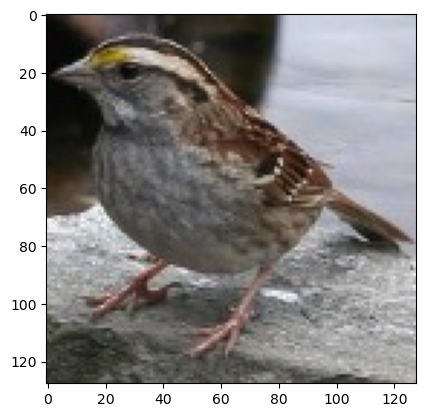

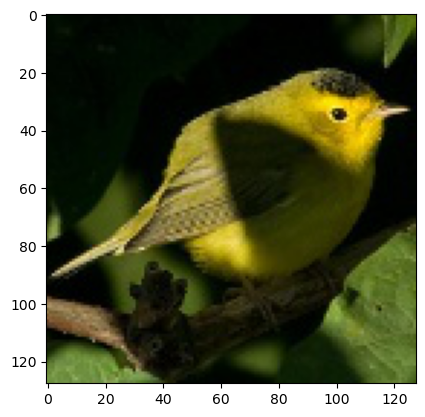

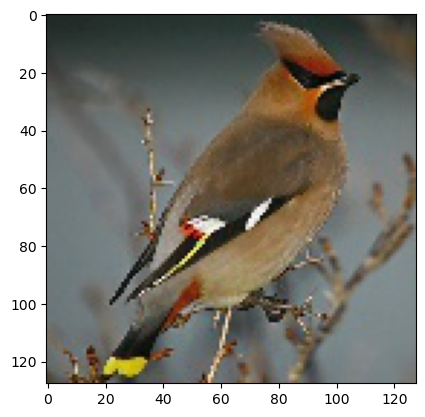

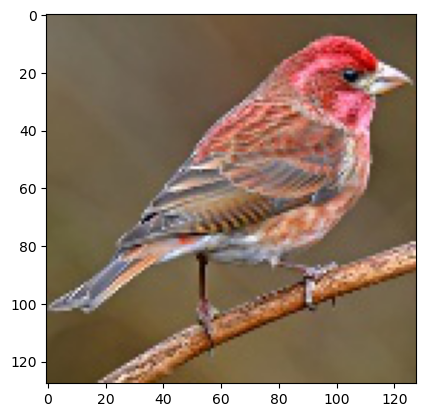

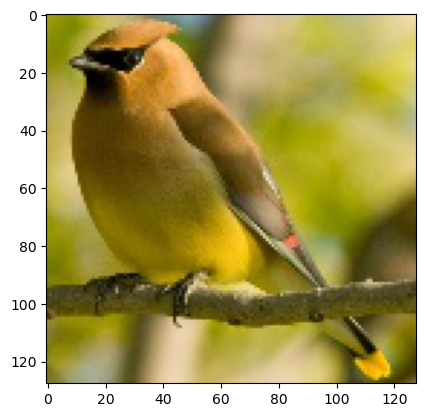

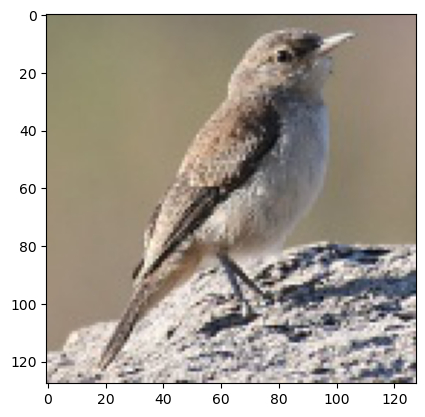

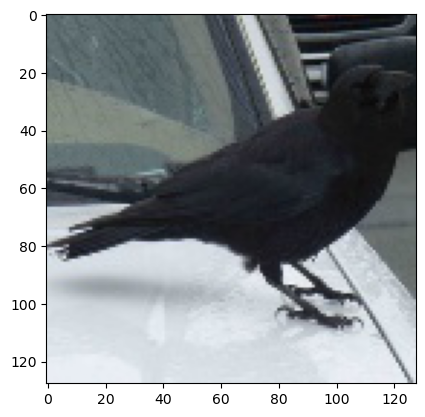

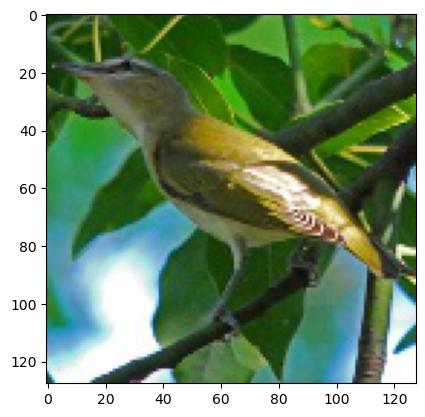

In [13]:
dataloader = get_dataloader(OUTPUT_DIRPATH, OUTPUTLIST_FILEPATH, df)

for images, _ in dataloader:
    for image in images:
        plt.imshow(image.permute(1, 2, 0))  # Assuming images are in tensor format
        plt.show()
    break